# Assignment #2 Backpropogation 
## 1. Getting Started

In [1]:
import numpy as np
from matplotlib import pyplot

## 2. Read MNIST Data

In [2]:
import MNISTtools
# help(MNISTtools.load)
# help(MNISTtools.show)

In [3]:
xtrain, ltrain = MNISTtools.load(dataset = "training", path = "/datasets/MNIST")
print(xtrain.shape)
print(ltrain.shape)

(784, 60000)
(60000,)


### 2.1
What are the shapes of both variables? <br>
&nbsp;&nbsp;&nbsp;&nbsp;xtrain - (784, 60000), ltrain - (60000, 0)<br>
Whare is the size of the training dataset?<br>
&nbsp;&nbsp;&nbsp;&nbsp;60,000 images<br>
What is the feature dimension?<br>
&nbsp;&nbsp;&nbsp;&nbsp;784

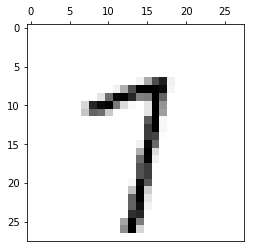

In [4]:
MNISTtools.show(xtrain[:, 42])

In [5]:
print(ltrain[42])
print('Min: ', np.amin(xtrain), 'Max: ', np.amax(xtrain))

7
('Min: ', 0, 'Max: ', 255)


### 2.3
What is the range of xtrain(min and max values)?<br> 
&nbsp;&nbsp;&nbsp;&nbsp;0 - 255<br>
What is the type of xtrain?<br>
&nbsp;&nbsp;&nbsp;&nbsp; xtrain is a numpy.ndarray
### 2.4 Normalize Images

In [6]:
def normalize_MNIST_images(x):
    # Normalize images from to [-1, 1]
    x = x.astype(np.float64) # convert to float
    xmax, xmin = x.max(), x.min()
    x = 2 * (x - xmin)/(xmax - xmin) - 1
    return x

#### Check normalize_MNIST_images()

In [7]:
xtrain = normalize_MNIST_images(xtrain)
print('Min: ', xtrain.min(), 'Max: ', xtrain.max()) 
print(xtrain.shape)

('Min: ', -1.0, 'Max: ', 1.0)
(784, 60000)


### 2.5  Convert labels to oneHot codes

In [8]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size)) 
    d[lbl, np.arange(0, lbl.size)] = 1 
    return d

#### Check label conversion

In [9]:
dtrain = label2onehot(ltrain)
print(dtrain.shape)
print(dtrain[:, 42])
print (ltrain[42])

(10, 60000)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


The one hot label of image 42, [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], is the correct binary vector representation of label 7.

### 2.6 Convert oneHot codes to labels

In [10]:
def onehot2label(d):
    lbl = d.argmax(axis=0) # need the max of each row
    return lbl

#### Check oneHot conversion

In [11]:
if np.array_equal(ltrain,onehot2label(dtrain)):
    print('One hot encoding and decoding successful')

One hot encoding and decoding successful


## 3. Activation functions
### 3.7 Numerically safe softmax

In [12]:
def softmax(a):
    # Compute softmax
    ga = np.exp(a - a.max(axis=0))
    return ga / ga.sum(axis=0)

#### Testing softmax

In [13]:
x2 = np.array([[1, 2, 1, 6],  # sample 1
               [2, 4, 2, 6],  # sample 2
               [1, 2, 1, 6]]) # sample 1 again(!)
print(softmax(x2))

[[0.21194156 0.10650698 0.21194156 0.33333333]
 [0.57611688 0.78698604 0.57611688 0.33333333]
 [0.21194156 0.10650698 0.21194156 0.33333333]]


### 3.8 Softmax derivative if i = j
\begin{align}
{g(a)_i} & = \frac{\exp({a_i})}{\sum_{j=1}^n\exp({a_j})} \\
Using\space quotient\space rule \space and\space simplifying... \\
\frac{\partial{g(a)_i}}{\partial{a_j}}& = \frac{\exp({a_i})\sum_{k=1}^n(\exp({a_k})-\exp({a_j}))}
{\sum_{k=1}^n\exp({a_k})} \\
& = \frac{\exp({a_j})}{\sum_{k=1}^n\exp({a_k})} x 
\frac{\sum_{k=1}^n(\exp({a_k}) - \exp({a_j}))}{\sum_{k=1}^n\exp({a_k})} \\
& = {p_i}(1 - {p_j})
\end{align}

### 3.9 Softmax derivative if i != j

\begin{align}
\frac{\partial{g(a)_i}}{\partial{a_j}}& = \frac{0 - \exp({a_i})\exp({a_j})}
{(\sum_{k=1}^n\exp({a_k}))^2} \\
& = \frac{- \exp({a_j})}{\sum_{k=1}^n\exp({a_k})} x \frac{\exp({a_i})}{\sum_{k=1}^n\exp({a_k})} \\
& = -{p_j}{p_i}
\end{align}
### 3.10 softmaxp

In [14]:
def softmaxp(a, e):
    ga = softmax(a)
    prod = ga * e
    dot = (ga * e).sum(axis=0)
    return prod - dot.T * ga

### 3.11 Checking spftmaxp()

In [15]:
eps = 1e-6 #finite difference step
a = np.random.randn(10, 200) #random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
a_soft = softmax(a)
diff_approx = (softmax(a + e * eps) - a_soft) / eps
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, ' should be smaller than 1e-6')

(5.048422830729758e-07, ' should be smaller than 1e-6')


### 3.12 ReLU

In [16]:
def relu(a):
    return a * (a > 0) # for speed
def relup(a, e):
    return (1 * (a > 0)) * e

## 4. Backpropagation
### 4.13 Network init

In [17]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.) 
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.)) 
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.)) 
    return W1, b1, W2, b2

In [18]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

### 4.14  Forward prop

In [19]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    return y

In [20]:
yinit = forwardprop_shallow(xtrain, netinit)
print(yinit.shape)

(10, 60000)


### 4.15 eval loss

In [21]:
def eval_loss(y, d):
    result = -(d * np.log(y)).sum()/y.size
    return result

In [22]:
print(eval_loss(yinit, dtrain), 'should be around 0.26')

(0.25445753553865325, 'should be around 0.26')


### 4.16 Eval perfs

In [23]:
def eval_perfs(y, lbl):
    y[y.argmax(axis=0), np.arange(0, y.shape[1])] = 1
    y[y < 1] = 0
    predicted_labels = onehot2label(y)
    return 1 - float(np.sum(predicted_labels == lbl))/float(y.shape[1]) 
print(eval_perfs(yinit, ltrain))

0.889383333333


Initially the shallow net shows very poor performance.
### 4.17 Update shallow

In [63]:
def update_shallow(x, d, net, gamma=0.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    
    # forward phase
    a1 = W1.dot(x) + b1 # [10x60k]
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2 # [64x60k]
    y = softmax(a2)
    
    # error
    e = eval_loss(y, d)

    # backward phase
    delta2 = softmaxp(a2, -d/y)
    delta1 = relup(a1, W2.T.dot(delta2))
    
    # gradient update
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis=1).reshape(No, 1)
    b1 = b1 - gamma * delta1.sum(axis=1).reshape(Nh, 1)
    return W1, b1, W2, b2

### 4.18 Backprop shallow

In [56]:
def backprop_shallow(x, d, net, T, gamma=.05): 
    lbl = onehot2label(d)
    for t in range(0, T):
        net = update_shallow(x, d, net, gamma)
        y = forwardprop_shallow(x, net)
        if t % 5 == 0:
            print('T: ', t, 'Loss: ', eval_loss(y, d), 'Error: ', eval_perfs(y, lbl))
    return net

In [45]:
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)

('T: ', 0, 'Loss: ', 0.23502028504254116, 'Perfs: ', 0.8597666666666667)
('T: ', 1, 'Loss: ', 0.22191315018550548, 'Perfs: ', 0.79625)
('T: ', 2, 'Loss: ', 0.2133725449748527, 'Perfs: ', 0.7170000000000001)
('T: ', 3, 'Loss: ', 0.20592179394480806, 'Perfs: ', 0.6618999999999999)
('T: ', 4, 'Loss: ', 0.19885955796734722, 'Perfs: ', 0.61605)
('T: ', 5, 'Loss: ', 0.1921007871656288, 'Perfs: ', 0.5789833333333334)
('T: ', 6, 'Loss: ', 0.18553236104294654, 'Perfs: ', 0.5438833333333333)
('T: ', 7, 'Loss: ', 0.17910571722706264, 'Perfs: ', 0.5125500000000001)
('T: ', 8, 'Loss: ', 0.17282287408678673, 'Perfs: ', 0.4824166666666667)
('T: ', 9, 'Loss: ', 0.16675339508526865, 'Perfs: ', 0.4548)
('T: ', 10, 'Loss: ', 0.16094753133534162, 'Perfs: ', 0.43115000000000003)
('T: ', 11, 'Loss: ', 0.1554552467748824, 'Perfs: ', 0.4072)
('T: ', 12, 'Loss: ', 0.15025994391361944, 'Perfs: ', 0.3899)
('T: ', 13, 'Loss: ', 0.14535652582947692, 'Perfs: ', 0.36998333333333333)
('T: ', 14, 'Loss: ', 0.140742339

With 100 iterations The error reaches 13.1% and the loss is 0.049.
### 4.19 Testing


In [49]:
xtest, ltest = MNISTtools.load(dataset = "testing", path = "/datasets/MNIST")
print(xtest.shape, ltest.shape)
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)

((784, 10000), (10000,))


The testing dataset has 10,000 images. 

In [64]:
nettest = backprop_shallow(xtest, dtest, nettrain, 100)

('T: ', 0, 'Loss: ', 0.04638367067298492, 'Error: ', 0.123)
('T: ', 5, 'Loss: ', 0.045225261173635956, 'Error: ', 0.12090000000000001)
('T: ', 10, 'Loss: ', 0.04420500707203926, 'Error: ', 0.11829999999999996)
('T: ', 15, 'Loss: ', 0.04328932265501037, 'Error: ', 0.11619999999999997)
('T: ', 20, 'Loss: ', 0.042459733558906886, 'Error: ', 0.11470000000000002)
('T: ', 25, 'Loss: ', 0.04170234504843045, 'Error: ', 0.11229999999999996)
('T: ', 30, 'Loss: ', 0.04100489099865156, 'Error: ', 0.11070000000000002)
('T: ', 35, 'Loss: ', 0.040359409451545765, 'Error: ', 0.10929999999999995)
('T: ', 40, 'Loss: ', 0.03975975912818162, 'Error: ', 0.10770000000000002)
('T: ', 45, 'Loss: ', 0.039201119437916765, 'Error: ', 0.10609999999999997)
('T: ', 50, 'Loss: ', 0.03867729519928849, 'Error: ', 0.10519999999999996)
('T: ', 55, 'Loss: ', 0.03818526603348765, 'Error: ', 0.10450000000000004)
('T: ', 60, 'Loss: ', 0.0377213584864051, 'Error: ', 0.1038)
('T: ', 65, 'Loss: ', 0.03728282751217023, 'Error: 

The trained network had much better performance and ran much faster. The error after 100 iterations was 9% and the loss was 0.034. 
### 4.20 Minibatch

In [55]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05): 
    N = x.shape[1]
    lbl = onehot2label(d)
    for t in range(0, T):
        for l in range(0, (N+B-1)/B):
            idx = np.arange(B*l, min(B*(l+1), N))
            net = update_shallow(x[:,idx], d[:,idx], net, gamma)
        y = forwardprop_shallow(x, net)
        print('T: ', t, 'Loss: ', eval_loss(y, d), 'Error: ', eval_perfs(y, lbl))    
    return net
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)

('T: ', 0, 'Loss: ', 0.03529789509462131, 'Error: ', 0.11071666666666669)
('T: ', 1, 'Loss: ', 0.026923780882758215, 'Error: ', 0.08261666666666667)
('T: ', 2, 'Loss: ', 0.02186364931079035, 'Error: ', 0.06625000000000003)
('T: ', 3, 'Loss: ', 0.01912832861209897, 'Error: ', 0.0587833333333333)
('T: ', 4, 'Loss: ', 0.016823098752241805, 'Error: ', 0.05123333333333335)


### 4.21 Minibatch testing

In [66]:
netminibatchtest = backprop_minibatch_shallow(xtest, dtest, netminibatch, 5, B=100)

('T: ', 0, 'Loss: ', 0.01480992124528303, 'Error: ', 0.044499999999999984)
('T: ', 1, 'Loss: ', 0.013699655423460428, 'Error: ', 0.042200000000000015)
('T: ', 2, 'Loss: ', 0.012932930874962036, 'Error: ', 0.03969999999999996)
('T: ', 3, 'Loss: ', 0.012188205345256612, 'Error: ', 0.0373)
('T: ', 4, 'Loss: ', 0.011522161707503835, 'Error: ', 0.03520000000000001)


The minibatch algorithm is more efficient and has less error. For 5 epochs with minibatch size of 100, the error was 3.5% and the loss was 0.011. This is superior to the standard backprop algorithm.
### 4.22 More hidden nodes, minibatch algorithm

In [71]:
netinit16 = init_shallow(Ni, 16, No)
nettrain16  = backprop_minibatch_shallow(xtrain, dtrain, netinit16, 5, B=100)

('T: ', 0, 'Loss: ', 0.04002498231983609, 'Error: ', 0.12791666666666668)
('T: ', 1, 'Loss: ', 0.032066780781495684, 'Error: ', 0.1001333333333333)
('T: ', 2, 'Loss: ', 0.02929111365247636, 'Error: ', 0.09145000000000003)
('T: ', 3, 'Loss: ', 0.02692495868298967, 'Error: ', 0.0837)
('T: ', 4, 'Loss: ', 0.025539702025705695, 'Error: ', 0.07916666666666672)


In [73]:
nettest16  = backprop_minibatch_shallow(xtrain, dtrain, nettrain16, 5, B=100)

('T: ', 0, 'Loss: ', 0.024544890735134224, 'Error: ', 0.07563333333333333)
('T: ', 1, 'Loss: ', 0.02375407976651502, 'Error: ', 0.07316666666666671)
('T: ', 2, 'Loss: ', 0.023269078628798023, 'Error: ', 0.07153333333333334)
('T: ', 3, 'Loss: ', 0.022662641515778563, 'Error: ', 0.06963333333333332)
('T: ', 4, 'Loss: ', 0.02258204548738588, 'Error: ', 0.06993333333333329)


Increasing the number of hidden units to 16 did not improve the loss or error. At 100 iterations the error was 6.9% and the loss was 0.012.

In [74]:
netinit256 = init_shallow(Ni, 256, No)
nettrain256  = backprop_minibatch_shallow(xtrain, dtrain, netinit256, 5, B=100)

('T: ', 0, 'Loss: ', 0.030651057480846993, 'Error: ', 0.09550000000000003)
('T: ', 1, 'Loss: ', 0.023019820728543514, 'Error: ', 0.0713166666666667)
('T: ', 2, 'Loss: ', 0.018792362223676667, 'Error: ', 0.05783333333333329)
('T: ', 3, 'Loss: ', 0.015856981211198815, 'Error: ', 0.04795000000000005)
('T: ', 4, 'Loss: ', 0.013675140828283574, 'Error: ', 0.04079999999999995)


In [75]:
nettest256  = backprop_minibatch_shallow(xtrain, dtrain, nettrain256, 5, B=100)

('T: ', 0, 'Loss: ', 0.012012696133176763, 'Error: ', 0.03598333333333337)
('T: ', 1, 'Loss: ', 0.010663653351011835, 'Error: ', 0.03211666666666668)
('T: ', 2, 'Loss: ', 0.009620223740400639, 'Error: ', 0.028766666666666718)
('T: ', 3, 'Loss: ', 0.008748225762343504, 'Error: ', 0.026116666666666677)
('T: ', 4, 'Loss: ', 0.007944758098283487, 'Error: ', 0.02371666666666672)


Increasing the number of hidden units to 256 improved the loss and error. At 100 iterations the error was 2.3% and the loss was 0.007.